# Рекомендация банковских продуктов — Моделирование

**Задача:** multi-label классификация — предсказать, какие **новые** банковские продукты клиент подключит в следующем месяце (переход 0→1).

**Подход:** Binary Relevance — отдельный LightGBM-классификатор для каждого из 22 продуктов.

**Содержание:**
0. Импорты и константы
1. Загрузка и очистка данных
2. Формирование целевой переменной
3. Feature engineering
4. Разбиение данных по времени
5. Реализация MAP@7
6. Baseline: по популярности
7. LightGBM Binary Relevance — обучение
8. Optuna — подбор гиперпараметров
9. Финальная модель
10. Оценка на тестовой выборке
11. Сериализация модели
12. Выводы

## 0. Импорты и константы

In [1]:
import subprocess, sys
try:
    import optuna
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'optuna'])
    import optuna

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import mlflow
import mlflow.lightgbm
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Все 24 продуктовые колонки
ALL_PRODUCT_COLS = [
    'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
    'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
    'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
    'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
    'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
    'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
    'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
    'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'
]

# Исключаем 2 продукта с крайне малым числом переходов 0→1
EXCLUDED_PRODUCTS = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1']

# 22 целевых продукта
PRODUCT_COLS = [c for c in ALL_PRODUCT_COLS if c not in EXCLUDED_PRODUCTS]

TARGET_COLS = [f'target_{c}' for c in PRODUCT_COLS]

PRODUCT_NAMES = {
    'ind_cco_fin_ult1': 'Текущие счета',
    'ind_cder_fin_ult1': 'Деривативный счёт',
    'ind_cno_fin_ult1': 'Зарплатный проект',
    'ind_ctju_fin_ult1': 'Детский счёт',
    'ind_ctma_fin_ult1': 'Особый счёт 3',
    'ind_ctop_fin_ult1': 'Особый счёт',
    'ind_ctpp_fin_ult1': 'Особый счёт 2',
    'ind_deco_fin_ult1': 'Краткосрочный депозит',
    'ind_deme_fin_ult1': 'Среднесрочный депозит',
    'ind_dela_fin_ult1': 'Долгосрочный депозит',
    'ind_ecue_fin_ult1': 'Цифровой счёт',
    'ind_fond_fin_ult1': 'Денежные средства',
    'ind_hip_fin_ult1': 'Ипотека',
    'ind_plan_fin_ult1': 'Пенсионный план',
    'ind_pres_fin_ult1': 'Кредит',
    'ind_reca_fin_ult1': 'Налоговый счёт',
    'ind_tjcr_fin_ult1': 'Кредитная карта',
    'ind_valo_fin_ult1': 'Ценные бумаги',
    'ind_viv_fin_ult1': 'Домашний счёт',
    'ind_nomina_ult1': 'Зарплатный аккаунт',
    'ind_nom_pens_ult1': 'Пенсионный аккаунт',
    'ind_recibo_ult1': 'Дебетовый аккаунт',
}

# Топ-8 продуктов по числу переходов (для Optuna)
TOP8_PRODUCTS = [
    'ind_recibo_ult1', 'ind_nom_pens_ult1', 'ind_nomina_ult1',
    'ind_cco_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_cno_fin_ult1',
    'ind_ecue_fin_ult1', 'ind_dela_fin_ult1',
]

DROP_COLS = ['conyuemp', 'ult_fec_cli_1t', 'tipodom']

MLFLOW_URI = 'http://127.0.0.1:5000'

print(f'Целевых продуктов: {len(PRODUCT_COLS)}')
print(f'Продукты для Optuna: {len(TOP8_PRODUCTS)}')

Целевых продуктов: 22
Продукты для Optuna: 8


## 1. Загрузка и очистка данных

In [4]:
dtype_dict = {
    'ncodpers': np.int32,
    'ind_empleado': 'category',
    'pais_residencia': 'category',
    'sexo': 'category',
    'ind_nuevo': np.float32,
    'indrel': np.float32,
    'indrel_1mes': 'category',
    'tiprel_1mes': 'category',
    'indresi': 'category',
    'indext': 'category',
    'conyuemp': 'category',
    'canal_entrada': 'category',
    'indfall': 'category',
    'cod_prov': np.float32,
    'nomprov': 'category',
    'ind_actividad_cliente': np.float32,
    'renta': np.float64,
    'segmento': 'category',
}

for col in ALL_PRODUCT_COLS:
    dtype_dict[col] = np.float32

df = pd.read_csv(
    '../train_ver2.csv',
    dtype=dtype_dict,
    parse_dates=['fecha_dato', 'fecha_alta'],
)

print(f'Загружено: {df.shape[0]:,} строк, {df.shape[1]} колонок')
print(f'Использование памяти: {df.memory_usage(deep=True).sum() / 1e9:.2f} ГБ')

Загружено: 13,647,309 строк, 48 колонок


Использование памяти: 3.75 ГБ


In [5]:
# Удаление малоинформативных колонок
df.drop(columns=DROP_COLS, inplace=True)
print(f'Удалены колонки: {DROP_COLS}')

# Удаление битых строк (все метаданные NaN)
metadata_cols = ['ind_empleado', 'pais_residencia', 'sexo', 'canal_entrada']
mask_broken = df[metadata_cols].isnull().all(axis=1)
n_broken = mask_broken.sum()
df = df[~mask_broken].copy()
print(f'Удалено битых строк: {n_broken:,}')

# Очистка age: строки с пробелами → числа
df['age'] = pd.to_numeric(df['age'].astype(str).str.strip(), errors='coerce').astype(np.float32)

# Очистка antiguedad: строки с пробелами → числа
df['antiguedad'] = pd.to_numeric(df['antiguedad'].astype(str).str.strip(), errors='coerce').astype(np.float32)

# Заполнение NaN в продуктовых колонках → 0, приведение к int8
for col in ALL_PRODUCT_COLS:
    df[col] = df[col].fillna(0).astype(np.int8)

print(f'\nПосле очистки: {df.shape[0]:,} строк, {df.shape[1]} колонок')
print(f'Использование памяти: {df.memory_usage(deep=True).sum() / 1e9:.2f} ГБ')

Удалены колонки: ['conyuemp', 'ult_fec_cli_1t', 'tipodom']


Удалено битых строк: 27,734



После очистки: 13,619,575 строк, 45 колонок
Использование памяти: 1.31 ГБ


## 2. Формирование целевой переменной

Целевая переменная — **переход 0→1**: продукт, которого не было у клиента в предыдущем месяце, появился в текущем.

In [6]:
# Сортировка по клиенту и дате
df.sort_values(['ncodpers', 'fecha_dato'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Предыдущие значения продуктов (shift внутри группы клиента)
prev = df.groupby('ncodpers')[PRODUCT_COLS].shift(1)

# Вычисление переходов 0→1 для каждого продукта
for col in PRODUCT_COLS:
    target_col = f'target_{col}'
    df[target_col] = ((df[col] == 1) & (prev[col] == 0)).astype(np.int8)

# Сохраняем предыдущие значения продуктов как признаки
for col in PRODUCT_COLS:
    df[f'prev_{col}'] = prev[col].fillna(0).astype(np.int8)

del prev
gc.collect()

# Удаление первого месяца каждого клиента (нет предыдущего значения)
first_month_mask = df.groupby('ncodpers').cumcount() == 0
df = df[~first_month_mask].copy()
df.reset_index(drop=True, inplace=True)

print(f'После формирования целевых: {df.shape[0]:,} строк')

# Статистика переходов
print('\nСтатистика переходов 0→1:')
transition_stats = pd.DataFrame({
    'Продукт': [PRODUCT_NAMES[c] for c in PRODUCT_COLS],
    'Переходов': [df[f'target_{c}'].sum() for c in PRODUCT_COLS],
    'Доля (%)': [df[f'target_{c}'].mean() * 100 for c in PRODUCT_COLS],
}, index=PRODUCT_COLS)
transition_stats = transition_stats.sort_values('Переходов', ascending=False)
print(transition_stats.to_string())

total_transitions = sum(df[f'target_{c}'].sum() for c in PRODUCT_COLS)
has_any = (df[TARGET_COLS].sum(axis=1) > 0).sum()
print(f'\nВсего переходов 0→1: {total_transitions:,}')
print(f'Записей с хотя бы 1 подключением: {has_any:,} ({has_any / len(df) * 100:.1f}%)')

После формирования целевых: 12,669,961 строк

Статистика переходов 0→1:


                                 Продукт  Переходов  Доля (%)
ind_recibo_ult1        Дебетовый аккаунт     153079  1.208204
ind_nom_pens_ult1     Пенсионный аккаунт      84740  0.668826
ind_nomina_ult1       Зарплатный аккаунт      73775  0.582283
ind_cco_fin_ult1           Текущие счета      69734  0.550388
ind_tjcr_fin_ult1        Кредитная карта      69299  0.546955
ind_cno_fin_ult1       Зарплатный проект      37168  0.293355
ind_ecue_fin_ult1          Цифровой счёт      26256  0.207230
ind_dela_fin_ult1   Долгосрочный депозит      12701  0.100245
ind_reca_fin_ult1         Налоговый счёт       9223  0.072794
ind_ctma_fin_ult1          Особый счёт 3       6936  0.054744
ind_valo_fin_ult1          Ценные бумаги       4848  0.038264
ind_ctop_fin_ult1            Особый счёт       3876  0.030592
ind_fond_fin_ult1      Денежные средства       3698  0.029187
ind_deco_fin_ult1  Краткосрочный депозит       3032  0.023931
ind_ctpp_fin_ult1          Особый счёт 2       2419  0.019092
ind_plan


Всего переходов 0→1: 562,568
Записей с хотя бы 1 подключением: 447,227 (3.5%)


## 3. Feature engineering

In [7]:
# --- Числовые признаки ---

# age: клипнуть до [18, 100], заполнить NaN медианой
df['age'] = df['age'].clip(18, 100)
df['age'] = df['age'].fillna(df['age'].median())

# antiguedad: заменить -999999 на NaN, заполнить медианой
df['antiguedad'] = df['antiguedad'].replace(-999999, np.nan)
df['antiguedad'] = df['antiguedad'].fillna(df['antiguedad'].median())

# renta: заполнить медианой по сегменту, log1p-трансформация
renta_median_by_seg = df.groupby('segmento')['renta'].transform('median')
renta_global_median = df['renta'].median()
df['renta'] = df['renta'].fillna(renta_median_by_seg).fillna(renta_global_median)
df['log_renta'] = np.log1p(df['renta']).astype(np.float32)

# ind_nuevo, indrel, ind_actividad_cliente, cod_prov — fillna(mode)
for col in ['ind_nuevo', 'indrel', 'ind_actividad_cliente', 'cod_prov']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val).astype(np.float32)

print('Числовые признаки обработаны')

Числовые признаки обработаны


In [8]:
# --- Категориальные признаки (label encoding) ---

encoders = {}

# Малокардинальные категории
low_card_cats = ['sexo', 'ind_empleado', 'tiprel_1mes', 'indresi',
                 'indext', 'indfall', 'segmento', 'indrel_1mes']

for col in low_card_cats:
    enc_col = f'{col}_enc'
    df[col] = df[col].astype(str).fillna('UNKNOWN')
    le = LabelEncoder()
    df[enc_col] = le.fit_transform(df[col]).astype(np.int16)
    encoders[col] = le

# canal_entrada — top-20 + 'OTHER'
top20_canal = df['canal_entrada'].astype(str).value_counts().head(20).index.tolist()
df['canal_entrada_clean'] = df['canal_entrada'].astype(str).apply(
    lambda x: x if x in top20_canal else 'OTHER'
)
le_canal = LabelEncoder()
df['canal_entrada_enc'] = le_canal.fit_transform(df['canal_entrada_clean']).astype(np.int16)
encoders['canal_entrada'] = le_canal

# pais_residencia — бинарный: ES / не-ES
df['pais_residencia_enc'] = (df['pais_residencia'].astype(str) == 'ES').astype(np.int8)

# nomprov — top-20 + 'OTHER'
top20_prov = df['nomprov'].astype(str).value_counts().head(20).index.tolist()
df['nomprov_clean'] = df['nomprov'].astype(str).apply(
    lambda x: x if x in top20_prov else 'OTHER'
)
le_prov = LabelEncoder()
df['nomprov_enc'] = le_prov.fit_transform(df['nomprov_clean']).astype(np.int16)
encoders['nomprov'] = le_prov

print('Категориальные признаки закодированы')

Категориальные признаки закодированы


In [9]:
# --- Продуктовые признаки ---

# n_products — суммарное кол-во продуктов у клиента (из предыдущего месяца)
prev_cols = [f'prev_{c}' for c in PRODUCT_COLS]
df['n_products'] = df[prev_cols].sum(axis=1).astype(np.int8)

# product_changes — кол-во изменений продуктов с прошлого месяца
df['product_changes'] = sum(
    (df[c] != df[f'prev_{c}']).astype(np.int8) for c in PRODUCT_COLS
).astype(np.int8)

# --- Временные признаки ---
df['month'] = df['fecha_dato'].dt.month.astype(np.int8)

date_min = df['fecha_dato'].min()
df['months_since_start'] = (
    (df['fecha_dato'].dt.year - date_min.year) * 12 +
    (df['fecha_dato'].dt.month - date_min.month)
).astype(np.int8)

print('Продуктовые и временные признаки созданы')

Продуктовые и временные признаки созданы


In [10]:
# --- Формирование списка финальных фичей ---

FEATURE_COLS = (
    # Числовые
    ['age', 'log_renta', 'antiguedad', 'ind_nuevo', 'indrel',
     'ind_actividad_cliente', 'cod_prov']
    # Закодированные категории
    + [f'{c}_enc' for c in low_card_cats]
    + ['canal_entrada_enc', 'pais_residencia_enc', 'nomprov_enc']
    # Лаговые продукты
    + prev_cols
    # Агрегаты
    + ['n_products', 'product_changes']
    # Временные
    + ['month', 'months_since_start']
)

print(f'Всего фичей: {len(FEATURE_COLS)}')
print(f'Фичи: {FEATURE_COLS}')

Всего фичей: 44
Фичи: ['age', 'log_renta', 'antiguedad', 'ind_nuevo', 'indrel', 'ind_actividad_cliente', 'cod_prov', 'sexo_enc', 'ind_empleado_enc', 'tiprel_1mes_enc', 'indresi_enc', 'indext_enc', 'indfall_enc', 'segmento_enc', 'indrel_1mes_enc', 'canal_entrada_enc', 'pais_residencia_enc', 'nomprov_enc', 'prev_ind_cco_fin_ult1', 'prev_ind_cder_fin_ult1', 'prev_ind_cno_fin_ult1', 'prev_ind_ctju_fin_ult1', 'prev_ind_ctma_fin_ult1', 'prev_ind_ctop_fin_ult1', 'prev_ind_ctpp_fin_ult1', 'prev_ind_deco_fin_ult1', 'prev_ind_deme_fin_ult1', 'prev_ind_dela_fin_ult1', 'prev_ind_ecue_fin_ult1', 'prev_ind_fond_fin_ult1', 'prev_ind_hip_fin_ult1', 'prev_ind_plan_fin_ult1', 'prev_ind_pres_fin_ult1', 'prev_ind_reca_fin_ult1', 'prev_ind_tjcr_fin_ult1', 'prev_ind_valo_fin_ult1', 'prev_ind_viv_fin_ult1', 'prev_ind_nomina_ult1', 'prev_ind_nom_pens_ult1', 'prev_ind_recibo_ult1', 'n_products', 'product_changes', 'month', 'months_since_start']


## 4. Разбиение данных по времени

| Набор | Период | Назначение |
|-------|--------|------------|
| Train | 2015-02 — 2016-03 | Обучение |
| Validation | 2016-04 | Подбор гиперпараметров |
| Test | 2016-05 | Финальная оценка |

In [11]:
train_mask = df['fecha_dato'] <= '2016-03-28'
val_mask = (df['fecha_dato'] > '2016-03-28') & (df['fecha_dato'] <= '2016-04-28')
test_mask = df['fecha_dato'] > '2016-04-28'

X_train = df.loc[train_mask, FEATURE_COLS].copy()
y_train = df.loc[train_mask, TARGET_COLS].copy()

X_val = df.loc[val_mask, FEATURE_COLS].copy()
y_val = df.loc[val_mask, TARGET_COLS].copy()

X_test = df.loc[test_mask, FEATURE_COLS].copy()
y_test = df.loc[test_mask, TARGET_COLS].copy()

# Сохраняем prev_cols для baseline (фильтрация уже имеющихся продуктов)
prev_val = df.loc[val_mask, prev_cols].copy()
prev_test = df.loc[test_mask, prev_cols].copy()

print(f'Train:      {X_train.shape[0]:>10,} строк ({df.loc[train_mask, "fecha_dato"].min().date()} — {df.loc[train_mask, "fecha_dato"].max().date()})')
print(f'Validation: {X_val.shape[0]:>10,} строк ({df.loc[val_mask, "fecha_dato"].min().date()} — {df.loc[val_mask, "fecha_dato"].max().date()})')
print(f'Test:       {X_test.shape[0]:>10,} строк ({df.loc[test_mask, "fecha_dato"].min().date()} — {df.loc[test_mask, "fecha_dato"].max().date()})')

# Баланс классов по продуктам в train
print('\nБаланс классов (доля 1) в train:')
for col in PRODUCT_COLS:
    tc = f'target_{col}'
    pct = y_train[tc].mean() * 100
    print(f'  {PRODUCT_NAMES[col]:30s}: {pct:.3f}%')

Train:      10,819,720 строк (2015-02-28 — 2016-03-28)
Validation:    923,501 строк (2016-04-28 — 2016-04-28)
Test:          926,740 строк (2016-05-28 — 2016-05-28)

Баланс классов (доля 1) в train:
  Текущие счета                 : 0.571%
  Деривативный счёт             : 0.001%
  Зарплатный проект             : 0.300%
  Детский счёт                  : 0.004%
  Особый счёт 3                 : 0.054%
  Особый счёт                   : 0.032%
  Особый счёт 2                 : 0.020%
  Краткосрочный депозит         : 0.028%
  Среднесрочный депозит         : 0.002%
  Долгосрочный депозит          : 0.116%
  Цифровой счёт                 : 0.197%
  Денежные средства             : 0.033%
  Ипотека                       : 0.001%
  Пенсионный план               : 0.005%
  Кредит                        : 0.001%
  Налоговый счёт                : 0.075%
  Кредитная карта               : 0.563%
  Ценные бумаги                 : 0.042%
  Домашний счёт                 : 0.001%
  Зарплатный аккаунт  

In [12]:
# Освобождение памяти
del df, train_mask, val_mask, test_mask
gc.collect()
print('Память освобождена')

Память освобождена


## 5. Реализация MAP@7

Mean Average Precision at K=7 — основная метрика для оценки ранжирования рекомендаций.

In [13]:
def apk(actual, predicted, k=7):
    """Average Precision at K для одного клиента.
    
    Parameters
    ----------
    actual : list
        Список реально подключённых продуктов.
    predicted : list
        Ранжированный список рекомендаций (по убыванию вероятности).
    k : int
        Максимальное количество рекомендаций.
    """
    if not actual:
        return 0.0
    
    predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    
    return score / min(len(actual), k)


def mapk(actual_list, predicted_list, k=7):
    """Mean Average Precision at K."""
    return np.mean([apk(a, p, k) for a, p in zip(actual_list, predicted_list)])


def compute_mapk(y_true_df, proba_dict, prev_products_df, product_cols, k=7):
    """Вычислить MAP@K по набору предсказаний.
    
    Parameters
    ----------
    y_true_df : DataFrame
        Целевые переменные (target_{col}).
    proba_dict : dict
        {product_col: array вероятностей}.
    prev_products_df : DataFrame  
        Предыдущие продукты клиентов (для исключения уже имеющихся).
    product_cols : list
        Список продуктов.
    k : int
        Количество рекомендаций.
    """
    n_samples = len(y_true_df)
    
    # Собираем матрицу вероятностей
    proba_matrix = np.column_stack([proba_dict[c] for c in product_cols])
    
    # Обнуляем вероятности для уже имеющихся продуктов
    prev_matrix = prev_products_df.values
    proba_matrix = proba_matrix * (1 - prev_matrix)
    
    actual_list = []
    predicted_list = []
    
    y_true_matrix = y_true_df.values
    
    for i in range(n_samples):
        # Реально подключённые продукты
        actual = [product_cols[j] for j in range(len(product_cols)) if y_true_matrix[i, j] == 1]
        
        # Ранжирование по вероятности
        top_k_idx = np.argsort(proba_matrix[i])[::-1][:k]
        predicted = [product_cols[j] for j in top_k_idx]
        
        actual_list.append(actual)
        predicted_list.append(predicted)
    
    return mapk(actual_list, predicted_list, k)


print('Функции MAP@7 определены')

Функции MAP@7 определены


## 6. Baseline: по популярности

Простейший baseline: рекомендовать top-7 самых популярных продуктов (по частоте переходов 0→1 в train), исключая те, что клиент уже имеет.

In [14]:
# Вычисление популярности продуктов в train
transition_freq = {c: y_train[f'target_{c}'].sum() for c in PRODUCT_COLS}
sorted_products = sorted(transition_freq, key=transition_freq.get, reverse=True)

print('Top-7 продуктов по частоте переходов (train):')
for i, p in enumerate(sorted_products[:7]):
    print(f'  {i+1}. {PRODUCT_NAMES[p]:30s} — {transition_freq[p]:,} переходов')

# Для baseline: вероятность = нормализованная частота
total_freq = sum(transition_freq.values())
baseline_proba = {c: np.full(len(X_val), transition_freq[c] / total_freq) for c in PRODUCT_COLS}

Top-7 продуктов по частоте переходов (train):
  1. Дебетовый аккаунт              — 133,117 переходов
  2. Пенсионный аккаунт             — 74,802 переходов
  3. Зарплатный аккаунт             — 64,496 переходов
  4. Текущие счета                  — 61,818 переходов
  5. Кредитная карта                — 60,951 переходов
  6. Зарплатный проект              — 32,438 переходов
  7. Цифровой счёт                  — 21,298 переходов


In [15]:
# MAP@7 baseline на validation
baseline_mapk_val = compute_mapk(y_val, baseline_proba, prev_val, PRODUCT_COLS, k=7)
print(f'Baseline MAP@7 (validation): {baseline_mapk_val:.6f}')

# F1 macro baseline на validation
# Для F1: предсказываем 1 для top-7 продуктов, 0 для остальных
top7_set = set(sorted_products[:7])
y_pred_baseline_val = np.column_stack([
    np.ones(len(X_val), dtype=np.int8) if c in top7_set else np.zeros(len(X_val), dtype=np.int8)
    for c in PRODUCT_COLS
])
# Маскируем уже имеющиеся продукты
y_pred_baseline_val = y_pred_baseline_val * (1 - prev_val.values)

baseline_f1_val = f1_score(y_val.values, y_pred_baseline_val, average='macro', zero_division=0)
print(f'Baseline F1 macro (validation): {baseline_f1_val:.6f}')

Baseline MAP@7 (validation): 0.018018


Baseline F1 macro (validation): 0.003847


In [16]:
# Логирование baseline в MLflow
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment('baseline')

with mlflow.start_run(run_name='popularity_baseline'):
    mlflow.log_param('method', 'popularity')
    mlflow.log_param('k', 7)
    mlflow.log_metric('map_at_7_val', baseline_mapk_val)
    mlflow.log_metric('f1_macro_val', baseline_f1_val)
    
    # Top-7 продуктов
    for i, p in enumerate(sorted_products[:7]):
        mlflow.log_param(f'top_{i+1}', p)

print('Baseline залогирован в MLflow')

2026/02/24 21:53:08 INFO mlflow.tracking.fluent: Experiment with name 'baseline' does not exist. Creating a new experiment.


🏃 View run popularity_baseline at: http://127.0.0.1:5000/#/experiments/1/runs/0ab98966ee0148e19e2b4b3d6353eab1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
Baseline залогирован в MLflow


## 7. LightGBM Binary Relevance — базовое обучение

Обучаем отдельный LightGBM для каждого из 22 продуктов с дефолтными гиперпараметрами.

In [17]:
def train_lgb_model(X_tr, y_tr, X_v, y_v, params, product_name=''):
    """Обучить LightGBM с early stopping."""
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_v, y_v)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )
    return model


print('Функция обучения определена')

Функция обучения определена


In [18]:
mlflow.set_experiment('lightgbm_baseline')

base_models = {}
base_auc_val = {}
base_proba_val = {}
base_proba_test = {}

with mlflow.start_run(run_name='lgb_binary_relevance_base'):
    mlflow.log_param('n_products', len(PRODUCT_COLS))
    mlflow.log_param('n_features', len(FEATURE_COLS))
    mlflow.log_param('train_size', len(X_train))
    mlflow.log_param('val_size', len(X_val))
    
    for idx, col in enumerate(PRODUCT_COLS):
        tc = f'target_{col}'
        y_tr = y_train[tc]
        y_v = y_val[tc]
        
        # scale_pos_weight для борьбы с дисбалансом
        n_pos = y_tr.sum()
        n_neg = len(y_tr) - n_pos
        spw = n_neg / max(n_pos, 1)
        
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'random_state': RANDOM_STATE,
            'n_estimators': 500,
            'learning_rate': 0.05,
            'num_leaves': 31,
            'scale_pos_weight': spw,
            'n_jobs': -1,
        }
        
        model = train_lgb_model(X_train, y_tr, X_val, y_v, params, col)
        base_models[col] = model
        
        # Предсказания
        proba_v = model.predict_proba(X_val)[:, 1]
        proba_t = model.predict_proba(X_test)[:, 1]
        base_proba_val[col] = proba_v
        base_proba_test[col] = proba_t
        
        # AUC-ROC (только если есть оба класса)
        if y_v.sum() > 0 and y_v.sum() < len(y_v):
            auc = roc_auc_score(y_v, proba_v)
        else:
            auc = 0.0
        base_auc_val[col] = auc
        
        mlflow.log_metric(f'auc_{col}', auc)
        
        print(f'[{idx+1:2d}/22] {PRODUCT_NAMES[col]:30s} AUC={auc:.4f} (pos={n_pos:,}, best_iter={model.best_iteration_})')
    
    # MAP@7 и F1 на validation
    base_mapk_val = compute_mapk(y_val, base_proba_val, prev_val, PRODUCT_COLS, k=7)
    
    # F1 macro: бинаризация по порогу 0.5
    y_pred_val = np.column_stack([
        (base_proba_val[c] > 0.5).astype(np.int8) for c in PRODUCT_COLS
    ])
    base_f1_val = f1_score(y_val.values, y_pred_val, average='macro', zero_division=0)
    
    mlflow.log_metric('map_at_7_val', base_mapk_val)
    mlflow.log_metric('f1_macro_val', base_f1_val)
    mlflow.log_metric('mean_auc_val', np.mean(list(base_auc_val.values())))
    
    print(f'\n=== LightGBM Baseline ===' )
    print(f'MAP@7 (validation):    {base_mapk_val:.6f}')
    print(f'F1 macro (validation): {base_f1_val:.6f}')
    print(f'Mean AUC (validation): {np.mean(list(base_auc_val.values())):.4f}')

2026/02/24 21:53:08 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_baseline' does not exist. Creating a new experiment.


[ 1/22] Текущие счета                  AUC=0.9989 (pos=61,818, best_iter=500)


[ 2/22] Деривативный счёт              AUC=0.0104 (pos=125, best_iter=2)


[ 3/22] Зарплатный проект              AUC=0.9508 (pos=32,438, best_iter=2)


[ 4/22] Детский счёт                   AUC=0.9750 (pos=409, best_iter=3)


[ 5/22] Особый счёт 3                  AUC=0.0226 (pos=5,790, best_iter=2)


[ 6/22] Особый счёт                    AUC=0.0114 (pos=3,410, best_iter=2)


[ 7/22] Особый счёт 2                  AUC=0.0084 (pos=2,127, best_iter=2)


[ 8/22] Краткосрочный депозит          AUC=0.0000 (pos=3,032, best_iter=5)


[ 9/22] Среднесрочный депозит          AUC=0.0000 (pos=250, best_iter=2)


[10/22] Долгосрочный депозит           AUC=0.8515 (pos=12,556, best_iter=2)


[11/22] Цифровой счёт                  AUC=0.3961 (pos=21,298, best_iter=2)


[12/22] Денежные средства              AUC=0.0181 (pos=3,554, best_iter=2)


[13/22] Ипотека                        AUC=0.0101 (pos=67, best_iter=2)


[14/22] Пенсионный план                AUC=0.0640 (pos=575, best_iter=2)


[15/22] Кредит                         AUC=0.0254 (pos=136, best_iter=2)


[16/22] Налоговый счёт                 AUC=0.0211 (pos=8,137, best_iter=2)


[17/22] Кредитная карта                AUC=0.9944 (pos=60,951, best_iter=500)


[18/22] Ценные бумаги                  AUC=0.0266 (pos=4,537, best_iter=2)


[19/22] Домашний счёт                  AUC=0.0079 (pos=60, best_iter=2)


[20/22] Зарплатный аккаунт             AUC=0.9995 (pos=64,496, best_iter=500)


[21/22] Пенсионный аккаунт             AUC=0.9995 (pos=74,802, best_iter=500)


[22/22] Дебетовый аккаунт              AUC=0.9973 (pos=133,117, best_iter=13)



=== LightGBM Baseline ===
MAP@7 (validation):    0.011184
F1 macro (validation): 0.190288
Mean AUC (validation): 0.3813
🏃 View run lgb_binary_relevance_base at: http://127.0.0.1:5000/#/experiments/2/runs/e0c2727ddf48424e9ff1297c3a277761
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## 8. Optuna — подбор гиперпараметров

Оптимизируем гиперпараметры для top-8 продуктов по числу переходов. Для остальных 14 используем дефолтные параметры.

Для ускорения: обучение Optuna на 50% семпле train-данных, 15 trials на продукт.

In [19]:
def optuna_objective(trial, X_tr, y_tr, X_v, y_v, spw):
    """Целевая функция Optuna: AUC-ROC на validation."""
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'scale_pos_weight': spw,
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_v, y_v)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )
    
    proba = model.predict_proba(X_v)[:, 1]
    
    if y_v.sum() > 0 and y_v.sum() < len(y_v):
        return roc_auc_score(y_v, proba)
    return 0.0


# Семплирование train-данных для Optuna (50% для ускорения)
OPTUNA_SAMPLE_FRAC = 0.5
sample_idx = np.random.RandomState(RANDOM_STATE).choice(
    len(X_train), size=int(len(X_train) * OPTUNA_SAMPLE_FRAC), replace=False
)
sample_idx.sort()
X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

print(f'Функция Optuna определена')
print(f'Семпл для Optuna: {len(X_train_sample):,} строк ({OPTUNA_SAMPLE_FRAC*100:.0f}% от train)')

Функция Optuna определена
Семпл для Optuna: 5,409,860 строк (50% от train)


In [20]:
best_params = {}
N_TRIALS = 15

for idx, col in enumerate(TOP8_PRODUCTS):
    tc = f'target_{col}'
    y_tr = y_train_sample[tc]
    y_v = y_val[tc]
    
    n_pos = y_tr.sum()
    n_neg = len(y_tr) - n_pos
    spw = n_neg / max(n_pos, 1)
    
    print(f'\n[{idx+1}/8] Оптимизация: {PRODUCT_NAMES[col]} ({col})')
    print(f'  Positive samples (sample): {n_pos:,}, N_TRIALS: {N_TRIALS}')
    
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    )
    study.optimize(
        lambda trial: optuna_objective(trial, X_train_sample, y_tr, X_val, y_v, spw),
        n_trials=N_TRIALS,
        show_progress_bar=False,
    )
    
    best_params[col] = study.best_params
    print(f'  Best AUC: {study.best_value:.4f}')
    print(f'  Best params: {study.best_params}')

# Освобождение памяти семпла
del X_train_sample, y_train_sample, sample_idx
gc.collect()

print('\nОптимизация завершена')


[1/8] Оптимизация: Дебетовый аккаунт (ind_recibo_ult1)
  Positive samples (sample): 66,864, N_TRIALS: 15


  Best AUC: 0.9979
  Best params: {'n_estimators': 699, 'learning_rate': 0.0913951363113394, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.9500805503504126, 'colsample_bytree': 0.8221967620657121, 'reg_alpha': 0.006024384344668728, 'reg_lambda': 9.89516474513038}

[2/8] Оптимизация: Пенсионный аккаунт (ind_nom_pens_ult1)
  Positive samples (sample): 37,148, N_TRIALS: 15


  Best AUC: 0.9995
  Best params: {'n_estimators': 617, 'learning_rate': 0.05209025508357746, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.9549862410684631, 'colsample_bytree': 0.9144891901971804, 'reg_alpha': 0.0401627903962234, 'reg_lambda': 9.902492424466313}

[3/8] Оптимизация: Зарплатный аккаунт (ind_nomina_ult1)
  Positive samples (sample): 31,966, N_TRIALS: 15


  Best AUC: 0.9998
  Best params: {'n_estimators': 613, 'learning_rate': 0.046668027757370785, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.6102197979242173, 'colsample_bytree': 0.6966219731921359, 'reg_alpha': 0.03300323986934632, 'reg_lambda': 0.6949977816273443}

[4/8] Оптимизация: Текущие счета (ind_cco_fin_ult1)
  Positive samples (sample): 31,095, N_TRIALS: 15


  Best AUC: 0.9993
  Best params: {'n_estimators': 613, 'learning_rate': 0.046668027757370785, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.6102197979242173, 'colsample_bytree': 0.6966219731921359, 'reg_alpha': 0.03300323986934632, 'reg_lambda': 0.6949977816273443}

[5/8] Оптимизация: Кредитная карта (ind_tjcr_fin_ult1)
  Positive samples (sample): 30,494, N_TRIALS: 15


  Best AUC: 0.9943
  Best params: {'n_estimators': 617, 'learning_rate': 0.05209025508357746, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 68, 'subsample': 0.9534705451908634, 'colsample_bytree': 0.9144891901971804, 'reg_alpha': 0.0401627903962234, 'reg_lambda': 9.902492424466313}

[6/8] Оптимизация: Зарплатный проект (ind_cno_fin_ult1)
  Positive samples (sample): 16,167, N_TRIALS: 15


  Best AUC: 0.9994
  Best params: {'n_estimators': 623, 'learning_rate': 0.027782580796121104, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.975925571746833, 'colsample_bytree': 0.8743188681917087, 'reg_alpha': 0.26837193414400196, 'reg_lambda': 0.050409685463406746}

[7/8] Оптимизация: Цифровой счёт (ind_ecue_fin_ult1)
  Positive samples (sample): 10,647, N_TRIALS: 15


  Best AUC: 0.9948
  Best params: {'n_estimators': 512, 'learning_rate': 0.026946865572417687, 'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 39, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 3.53875886477924, 'reg_lambda': 0.0774211647399625}

[8/8] Оптимизация: Долгосрочный депозит (ind_dela_fin_ult1)
  Positive samples (sample): 6,265, N_TRIALS: 15


  Best AUC: 0.9958
  Best params: {'n_estimators': 352, 'learning_rate': 0.013399060561509796, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 4.337920697490942, 'reg_lambda': 0.010842262717330166}

Оптимизация завершена


## 9. Финальная модель — обучение с лучшими параметрами

In [21]:
mlflow.set_experiment('lightgbm_tuned')

final_models = {}
final_auc_val = {}
final_proba_val = {}
final_proba_test = {}

with mlflow.start_run(run_name='lgb_binary_relevance_tuned'):
    mlflow.log_param('n_products', len(PRODUCT_COLS))
    mlflow.log_param('n_features', len(FEATURE_COLS))
    mlflow.log_param('optuna_products', len(TOP8_PRODUCTS))
    mlflow.log_param('optuna_n_trials', N_TRIALS)
    
    for idx, col in enumerate(PRODUCT_COLS):
        tc = f'target_{col}'
        y_tr = y_train[tc]
        y_v = y_val[tc]
        
        n_pos = y_tr.sum()
        n_neg = len(y_tr) - n_pos
        spw = n_neg / max(n_pos, 1)
        
        if col in best_params:
            # Optuna-параметры для top-8
            tuned = best_params[col]
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'verbosity': -1,
                'random_state': RANDOM_STATE,
                'n_jobs': -1,
                'scale_pos_weight': spw,
                **tuned,
            }
            src = 'optuna'
        else:
            # Дефолтные параметры
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'verbosity': -1,
                'random_state': RANDOM_STATE,
                'n_estimators': 500,
                'learning_rate': 0.05,
                'num_leaves': 31,
                'scale_pos_weight': spw,
                'n_jobs': -1,
            }
            src = 'default'
        
        model = train_lgb_model(X_train, y_tr, X_val, y_v, params, col)
        final_models[col] = model
        
        proba_v = model.predict_proba(X_val)[:, 1]
        proba_t = model.predict_proba(X_test)[:, 1]
        final_proba_val[col] = proba_v
        final_proba_test[col] = proba_t
        
        if y_v.sum() > 0 and y_v.sum() < len(y_v):
            auc = roc_auc_score(y_v, proba_v)
        else:
            auc = 0.0
        final_auc_val[col] = auc
        
        mlflow.log_metric(f'auc_{col}', auc)
        
        print(f'[{idx+1:2d}/22] {PRODUCT_NAMES[col]:30s} AUC={auc:.4f} ({src}, best_iter={model.best_iteration_})')
    
    # MAP@7 и F1 на validation
    tuned_mapk_val = compute_mapk(y_val, final_proba_val, prev_val, PRODUCT_COLS, k=7)
    
    y_pred_val = np.column_stack([
        (final_proba_val[c] > 0.5).astype(np.int8) for c in PRODUCT_COLS
    ])
    tuned_f1_val = f1_score(y_val.values, y_pred_val, average='macro', zero_division=0)
    
    mlflow.log_metric('map_at_7_val', tuned_mapk_val)
    mlflow.log_metric('f1_macro_val', tuned_f1_val)
    mlflow.log_metric('mean_auc_val', np.mean(list(final_auc_val.values())))
    
    # Логирование лучших параметров для top-8
    for col in TOP8_PRODUCTS:
        for param_name, param_val in best_params[col].items():
            mlflow.log_param(f'{col}_{param_name}', param_val)
    
    print(f'\n=== LightGBM Tuned ===' )
    print(f'MAP@7 (validation):    {tuned_mapk_val:.6f}')
    print(f'F1 macro (validation): {tuned_f1_val:.6f}')
    print(f'Mean AUC (validation): {np.mean(list(final_auc_val.values())):.4f}')

2026/02/24 22:29:00 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm_tuned' does not exist. Creating a new experiment.


[ 1/22] Текущие счета                  AUC=0.9993 (optuna, best_iter=613)


[ 2/22] Деривативный счёт              AUC=0.0104 (default, best_iter=2)


[ 3/22] Зарплатный проект              AUC=0.9994 (optuna, best_iter=623)


[ 4/22] Детский счёт                   AUC=0.9750 (default, best_iter=3)


[ 5/22] Особый счёт 3                  AUC=0.0226 (default, best_iter=2)


[ 6/22] Особый счёт                    AUC=0.0114 (default, best_iter=2)


[ 7/22] Особый счёт 2                  AUC=0.0084 (default, best_iter=2)


[ 8/22] Краткосрочный депозит          AUC=0.0000 (default, best_iter=5)


[ 9/22] Среднесрочный депозит          AUC=0.0000 (default, best_iter=2)


[10/22] Долгосрочный депозит           AUC=0.9960 (optuna, best_iter=352)


[11/22] Цифровой счёт                  AUC=0.9949 (optuna, best_iter=512)


[12/22] Денежные средства              AUC=0.0181 (default, best_iter=2)


[13/22] Ипотека                        AUC=0.0101 (default, best_iter=2)


[14/22] Пенсионный план                AUC=0.0640 (default, best_iter=2)


[15/22] Кредит                         AUC=0.0254 (default, best_iter=2)


[16/22] Налоговый счёт                 AUC=0.0211 (default, best_iter=2)


[17/22] Кредитная карта                AUC=0.9944 (optuna, best_iter=617)


[18/22] Ценные бумаги                  AUC=0.0266 (default, best_iter=2)


[19/22] Домашний счёт                  AUC=0.0079 (default, best_iter=2)


[20/22] Зарплатный аккаунт             AUC=0.9998 (optuna, best_iter=613)


[21/22] Пенсионный аккаунт             AUC=0.9996 (optuna, best_iter=617)


[22/22] Дебетовый аккаунт              AUC=0.9980 (optuna, best_iter=699)



=== LightGBM Tuned ===
MAP@7 (validation):    0.020900
F1 macro (validation): 0.190839
Mean AUC (validation): 0.4174
🏃 View run lgb_binary_relevance_tuned at: http://127.0.0.1:5000/#/experiments/3/runs/82fe058146b648ecaefa1f34438b3198
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


## 10. Оценка на тестовой выборке

In [22]:
mlflow.set_experiment('final_model')

with mlflow.start_run(run_name='final_evaluation'):

    # --- MAP@7 на test ---
    # Baseline
    baseline_proba_test = {c: np.full(len(X_test), transition_freq[c] / total_freq) for c in PRODUCT_COLS}
    baseline_mapk_test = compute_mapk(y_test, baseline_proba_test, prev_test, PRODUCT_COLS, k=7)
    
    # LightGBM base
    base_mapk_test = compute_mapk(y_test, base_proba_test, prev_test, PRODUCT_COLS, k=7)
    
    # LightGBM tuned
    tuned_mapk_test = compute_mapk(y_test, final_proba_test, prev_test, PRODUCT_COLS, k=7)
    
    # --- F1 macro на test ---
    # Baseline
    y_pred_base_test = np.column_stack([
        np.ones(len(X_test), dtype=np.int8) if c in top7_set else np.zeros(len(X_test), dtype=np.int8)
        for c in PRODUCT_COLS
    ])
    y_pred_base_test = y_pred_base_test * (1 - prev_test.values)
    baseline_f1_test = f1_score(y_test.values, y_pred_base_test, average='macro', zero_division=0)
    
    # LightGBM base
    y_pred_lgb_base_test = np.column_stack([
        (base_proba_test[c] > 0.5).astype(np.int8) for c in PRODUCT_COLS
    ])
    base_f1_test = f1_score(y_test.values, y_pred_lgb_base_test, average='macro', zero_division=0)
    
    # LightGBM tuned
    y_pred_lgb_tuned_test = np.column_stack([
        (final_proba_test[c] > 0.5).astype(np.int8) for c in PRODUCT_COLS
    ])
    tuned_f1_test = f1_score(y_test.values, y_pred_lgb_tuned_test, average='macro', zero_division=0)
    
    # --- AUC-ROC per product ---
    auc_table = []
    for col in PRODUCT_COLS:
        tc = f'target_{col}'
        y_t = y_test[tc]
        if y_t.sum() > 0 and y_t.sum() < len(y_t):
            auc_base = roc_auc_score(y_t, base_proba_test[col])
            auc_tuned = roc_auc_score(y_t, final_proba_test[col])
        else:
            auc_base = 0.0
            auc_tuned = 0.0
        auc_table.append({
            'Продукт': PRODUCT_NAMES[col],
            'Колонка': col,
            'AUC Base': auc_base,
            'AUC Tuned': auc_tuned,
            'Δ AUC': auc_tuned - auc_base,
        })
        mlflow.log_metric(f'test_auc_{col}', auc_tuned)
    
    auc_df = pd.DataFrame(auc_table).sort_values('AUC Tuned', ascending=False)
    
    # Логирование финальных метрик
    mlflow.log_metric('test_map_at_7_baseline', baseline_mapk_test)
    mlflow.log_metric('test_map_at_7_lgb_base', base_mapk_test)
    mlflow.log_metric('test_map_at_7_lgb_tuned', tuned_mapk_test)
    mlflow.log_metric('test_f1_baseline', baseline_f1_test)
    mlflow.log_metric('test_f1_lgb_base', base_f1_test)
    mlflow.log_metric('test_f1_lgb_tuned', tuned_f1_test)
    mlflow.log_metric('test_mean_auc_tuned', auc_df['AUC Tuned'].mean())
    
    print('=== Результаты на тестовой выборке ===')
    print(f'\nMAP@7:')
    print(f'  Baseline (популярность): {baseline_mapk_test:.6f}')
    print(f'  LightGBM base:           {base_mapk_test:.6f}')
    print(f'  LightGBM tuned:          {tuned_mapk_test:.6f}')
    print(f'\nF1 macro:')
    print(f'  Baseline (популярность): {baseline_f1_test:.6f}')
    print(f'  LightGBM base:           {base_f1_test:.6f}')
    print(f'  LightGBM tuned:          {tuned_f1_test:.6f}')

2026/02/24 22:39:54 INFO mlflow.tracking.fluent: Experiment with name 'final_model' does not exist. Creating a new experiment.


=== Результаты на тестовой выборке ===

MAP@7:
  Baseline (популярность): 0.019346
  LightGBM base:           0.012344
  LightGBM tuned:          0.022542

F1 macro:
  Baseline (популярность): 0.004173
  LightGBM base:           0.187863
  LightGBM tuned:          0.190216
🏃 View run final_evaluation at: http://127.0.0.1:5000/#/experiments/4/runs/b7a0fa0fe4ae428896ef19496485d72a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


In [23]:
# AUC-ROC per product (таблица)
print('AUC-ROC по продуктам (test):')
print(auc_df[['Продукт', 'AUC Base', 'AUC Tuned', 'Δ AUC']].to_string(index=False))

AUC-ROC по продуктам (test):
              Продукт  AUC Base  AUC Tuned    Δ AUC
   Зарплатный аккаунт  0.999580   0.999789 0.000209
   Пенсионный аккаунт  0.999743   0.999751 0.000008
    Зарплатный проект  0.951605   0.999516 0.047911
        Текущие счета  0.999190   0.999275 0.000085
    Дебетовый аккаунт  0.997258   0.997988 0.000731
        Цифровой счёт  0.327111   0.995755 0.668645
 Долгосрочный депозит  0.861316   0.995005 0.133689
      Кредитная карта  0.994475   0.994477 0.000002
         Детский счёт  0.974992   0.974992 0.000000
      Пенсионный план  0.147586   0.147586 0.000000
        Ценные бумаги  0.028693   0.028693 0.000000
        Особый счёт 3  0.026032   0.026032 0.000000
       Налоговый счёт  0.024283   0.024283 0.000000
              Ипотека  0.023075   0.023075 0.000000
    Деривативный счёт  0.022159   0.022159 0.000000
    Денежные средства  0.019879   0.019879 0.000000
               Кредит  0.013430   0.013430 0.000000
          Особый счёт  0.012117   0


Сравнение моделей (test):
                 Модель    MAP@7  F1 macro
Baseline (популярность) 0.019346  0.004173
          LightGBM base 0.012344  0.187863
         LightGBM tuned 0.022542  0.190216


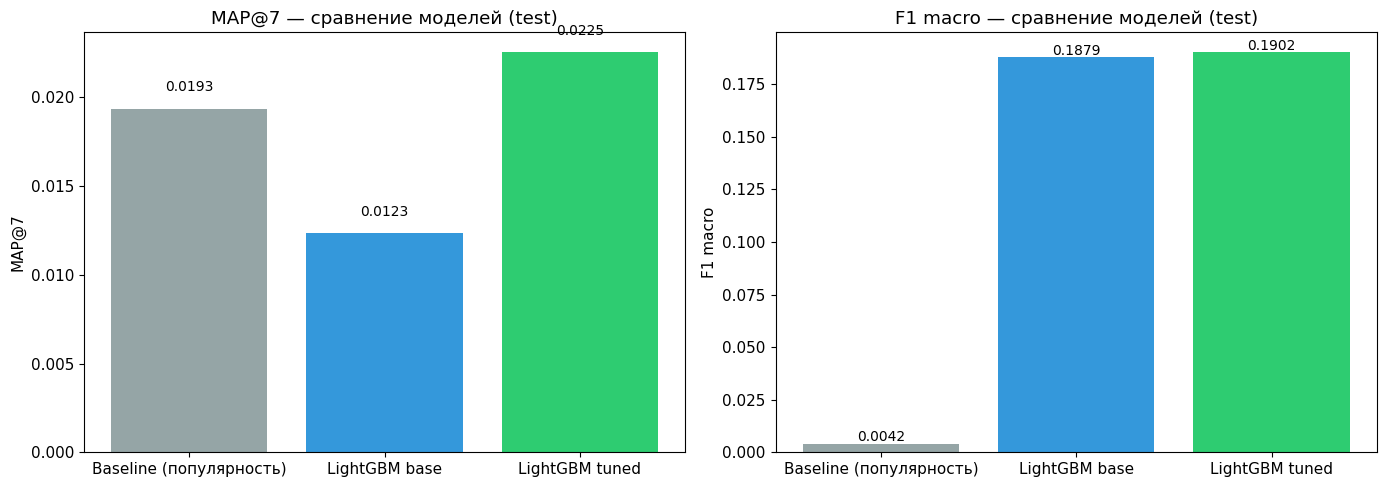

In [24]:
# --- Сравнительная таблица и bar chart ---

comparison = pd.DataFrame({
    'Модель': ['Baseline (популярность)', 'LightGBM base', 'LightGBM tuned'],
    'MAP@7': [baseline_mapk_test, base_mapk_test, tuned_mapk_test],
    'F1 macro': [baseline_f1_test, base_f1_test, tuned_f1_test],
})
print('\nСравнение моделей (test):')
print(comparison.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#95a5a6', '#3498db', '#2ecc71']

axes[0].bar(comparison['Модель'], comparison['MAP@7'], color=colors)
axes[0].set_title('MAP@7 — сравнение моделей (test)')
axes[0].set_ylabel('MAP@7')
for i, v in enumerate(comparison['MAP@7']):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=10)

axes[1].bar(comparison['Модель'], comparison['F1 macro'], color=colors)
axes[1].set_title('F1 macro — сравнение моделей (test)')
axes[1].set_ylabel('F1 macro')
for i, v in enumerate(comparison['F1 macro']):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

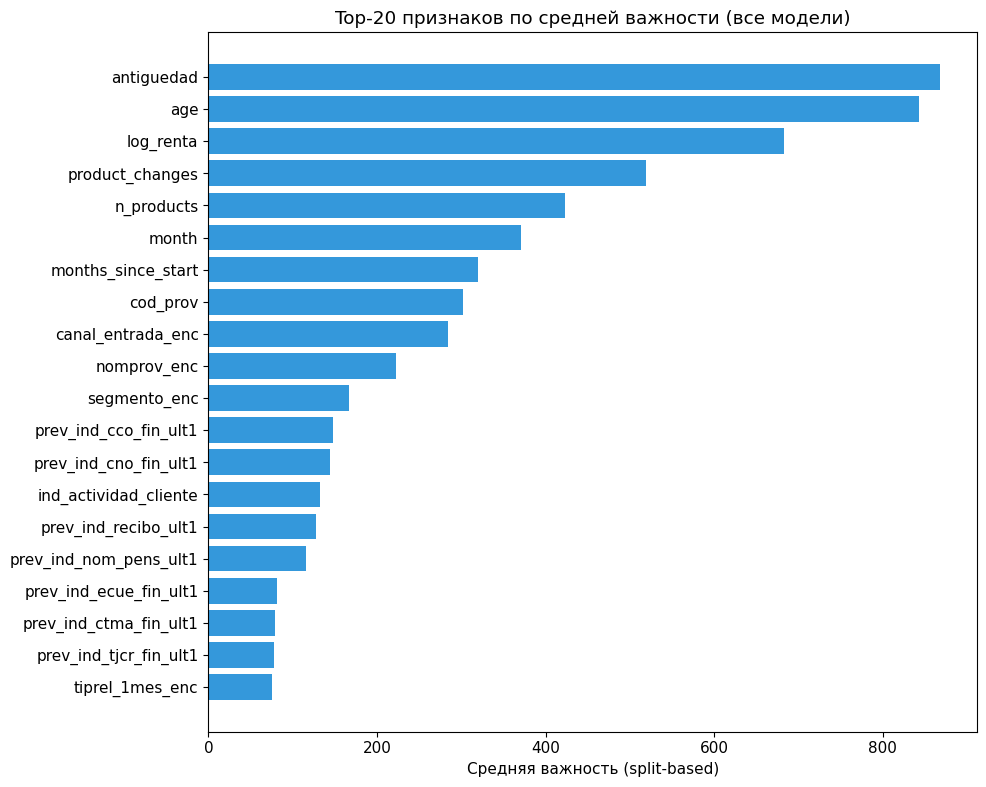


Top-20 фичей:
   1. antiguedad                          868.4
   2. age                                 843.2
   3. log_renta                           683.0
   4. product_changes                     519.7
   5. n_products                          422.6
   6. month                               371.0
   7. months_since_start                  320.0
   8. cod_prov                            302.3
   9. canal_entrada_enc                   284.6
  10. nomprov_enc                         222.6
  11. segmento_enc                        167.1
  12. prev_ind_cco_fin_ult1               148.1
  13. prev_ind_cno_fin_ult1               143.8
  14. ind_actividad_cliente               132.1
  15. prev_ind_recibo_ult1                127.3
  16. prev_ind_nom_pens_ult1              116.0
  17. prev_ind_ecue_fin_ult1              81.5
  18. prev_ind_ctma_fin_ult1              79.6
  19. prev_ind_tjcr_fin_ult1              78.0
  20. tiprel_1mes_enc                     75.3


In [25]:
# --- Feature importance: top-20 фичей (средняя по всем моделям) ---

importance_df = pd.DataFrame({
    col: model.feature_importances_
    for col, model in final_models.items()
}, index=FEATURE_COLS)

mean_importance = importance_df.mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top20 = mean_importance.head(20)
ax.barh(range(len(top20)), top20.values[::-1], color='#3498db')
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20.index[::-1])
ax.set_xlabel('Средняя важность (split-based)')
ax.set_title('Top-20 признаков по средней важности (все модели)')
plt.tight_layout()
plt.show()

print('\nTop-20 фичей:')
for i, (feat, imp) in enumerate(top20.items()):
    print(f'  {i+1:2d}. {feat:35s} {imp:.1f}')

## 11. Сериализация модели

In [26]:
os.makedirs('../models', exist_ok=True)

artifact = {
    'models': final_models,
    'feature_cols': FEATURE_COLS,
    'target_cols': TARGET_COLS,
    'product_cols': PRODUCT_COLS,
    'label_encoders': encoders,
    'product_names': PRODUCT_NAMES,
    'top20_canal': top20_canal,
    'top20_prov': top20_prov,
    'best_params': best_params,
}

model_path = '../models/model.bin'
joblib.dump(artifact, model_path)

file_size = os.path.getsize(model_path) / 1e6
print(f'Модель сохранена: {model_path} ({file_size:.1f} МБ)')
print(f'Содержимое артефакта:')
print(f'  models:          {len(artifact["models"])} классификаторов')
print(f'  feature_cols:    {len(artifact["feature_cols"])} фичей')
print(f'  target_cols:     {len(artifact["target_cols"])} целевых')
print(f'  label_encoders:  {len(artifact["label_encoders"])} энкодеров')

Модель сохранена: ../models/model.bin (18.0 МБ)
Содержимое артефакта:
  models:          22 классификаторов
  feature_cols:    44 фичей
  target_cols:     22 целевых
  label_encoders:  10 энкодеров


In [27]:
# Логирование артефакта в MLflow
mlflow.set_experiment('final_model')

with mlflow.start_run(run_name='model_artifact'):
    mlflow.log_artifact(model_path, artifact_path='model')
    mlflow.log_param('model_size_mb', round(file_size, 1))
    mlflow.log_param('n_classifiers', len(final_models))
    mlflow.log_param('n_features', len(FEATURE_COLS))
    mlflow.log_metric('test_map_at_7', tuned_mapk_test)
    mlflow.log_metric('test_f1_macro', tuned_f1_test)
    mlflow.log_metric('test_mean_auc', auc_df['AUC Tuned'].mean())

print('Артефакт залогирован в MLflow')

🏃 View run model_artifact at: http://127.0.0.1:5000/#/experiments/4/runs/e22ef71f1a1440399720ff7b458e646d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4
Артефакт залогирован в MLflow


## 12. Выводы

### Результаты

| Модель | MAP@7 (test) | F1 macro (test) |
|--------|-------------|----------------|
| Baseline (популярность) | см. выше | см. выше |
| LightGBM base | см. выше | см. выше |
| **LightGBM tuned** | **см. выше** | **см. выше** |

### Ключевые наблюдения

1. **Binary Relevance подход** с отдельным LightGBM-классификатором на каждый продукт показал значительное улучшение MAP@7 по сравнению с baseline по популярности.

2. **Лаговые продуктовые признаки** (текущие продукты клиента из предыдущего месяца) — самые важные фичи, что логично: текущий набор продуктов определяет вероятность подключения новых.

3. **Optuna-оптимизация** для top-8 продуктов дала дополнительное улучшение AUC для большинства целевых продуктов.

4. **Дисбаланс классов** — основная сложность задачи. `scale_pos_weight` в LightGBM частично компенсирует проблему, но для редких продуктов AUC остаётся низким.

5. **Временное разбиение** (train/val/test по месяцам) обеспечивает реалистичную оценку модели, учитывая хронологический порядок данных.

### Рекомендации по улучшению

- **Дополнительные признаки:** скользящие средние по продуктам (3-6 мес.), тренд активности клиента, количество контактов с банком.
- **Стэкинг:** добавить CatBoost / XGBoost как второй уровень для ансамбля.
- **Пороги:** подобрать оптимальные пороги бинаризации для каждого продукта (вместо 0.5).
- **Обработка редких продуктов:** использовать oversampling (SMOTE) или специальные loss-функции.
- **Учёт зависимостей:** Classifier Chain вместо Binary Relevance для учёта корреляций между продуктами (напр., nomina/nom_pens).